In [1]:
import pandas as pd
from pythainlp.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import normalize
from pythainlp.corpus import thai_stopwords
import numpy as np
import matplotlib.pyplot as plt
import re
import string

In [2]:
chatlog = pd.read_pickle('./data/chatlog.p')

In [3]:
df = chatlog[['userId', 'message', 'role', '_date']] 

In [4]:
# df.drop(df.loc[df.role == "Admin"].index, inplace=True)

In [5]:
df = df.loc[df.role=='User']

In [6]:
start_date = "2019-11-01"
end_date = "2019-11-04"

In [7]:
df_11_01 = df[(df._date >= start_date) & (df._date <= end_date)]

In [8]:
df_11_01

,userId,message,role,_date
0,2433413723406579,สวัสดี,User,2019-11-01
3,2433413723406579,สวัสดีครับ,User,2019-11-01
6,2433413723406579,สวัสดีจ้า,User,2019-11-04
9,2433413723406579,ไม่ต้องยุ่งอ่ะ,User,2019-11-04
11,2433413723406579,ไม่ต้องมาคุย,User,2019-11-04
...,...,...,...,...
182231,2765986723444282,ถ้ารถผ่อนมั้ยหมดทีจะได้มั้ยค่ะ,User,2019-11-04
182234,2765986723444282,กุ้ค่ะ,User,2019-11-04
182239,2969967083016774,เปิดรับพนักงานไหมค่ะ,User,2019-11-04
182241,3050730068273826,รถมอไซยังส่งไปหมด,User,2019-11-04


In [9]:
def get_th_tokens(text):
#     text = text.lower()
    text = text.replace('\n', ' ')
    tokens = word_tokenize(text, engine="newmm", keep_whitespace=False)
    return tokens

In [10]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('[.?]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[0-9]{1,10}', '', text)
    text = re.sub('นะ|น่ะ|น่า|น้า','',text)
    text = re.sub('คะ|ค่ะ|ค่า|คระ|คร่ะ|คร๊|ค๊','',text)
    text = re.sub('ครับ|คับ|คั้บ|ค้าบ|คร้าบ|คาฟ|ค้าฟ|ฮะ|ฮับ|ฮ้าฟ','',text)
    text = re.sub('จ้า|จ้ะ|จ๊ะ','',text)
    text = re.sub('หน่อย|น่อย','',text)
    text = re.sub('สวัสดี|หวัดดี','',text)
    text = re.sub('ของ','',text)
    # ลบ text ที่อยู่ในวงเล็บ <> ทั้งหมด
    text = re.sub(r'<.?>','', text)
    # ลบ hashtag
    text = re.sub(r'#','',text)
    # ลบ separator เช่น \n \t
    text = ' '.join(text.split())
    text = re.sub('สนใจ','',text)
    text = re.sub('อยากทราบว่า|อยากทราบ','',text)
    text = re.sub('รบกวนสอบถาม|ขอสอบถาม|สอบถาม','',text)
    text = re.sub('ปี','',text)
    text = re.sub('ขอบคุณ','',text)
    text = re.sub('ขอโทษ|ขอโทด','',text)
    text = re.sub('ขอ','',text)
    text = re.sub('ชั้น','',text)
    text = re.sub('เท่าไร|เท่าไหร่|เท่าหรั่ย|เท่าใด|เท่ารัย','',text)
    return text

In [11]:
df_11_01['message'] = df_11_01['message'].apply(lambda x: clean_text_round1(x))

/Users/phrare/NTL_dashboard/NTL/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
df_new = df_11_01.groupby(['userId'])['message'].apply(','.join).reset_index()

In [13]:
df_new["message_list"] = df_new["message"].apply(lambda x: x.split())

In [14]:
df_new.head()

,userId,message,message_list
0,1186000531525260,วีออสเท่าใรคั,[วีออสเท่าใรคั]
1,1217179911739736,"ป​​ผม​,วีโก้​แชมป์​​ประตู​","[ป​​ผม​,วีโก้​แชมป์​​ประตู​]"
2,1326518720805322,",ออนิว,","[,ออนิว,]"
3,1334390303260358,อยากกรณีจำนำเล่มทะเบียนรถยนต์ ต้องเปนผู้ครอบคร...,"[อยากกรณีจำนำเล่มทะเบียนรถยนต์, ต้องเปนผู้ครอบ..."
4,1343993022391031,,[]


In [15]:
vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(1,2)) 

In [16]:
vectorizer.fit(df_new['message']) 

TfidfVectorizer(ngram_range=(1, 2), token_pattern=None,
                tokenizer=<function get_th_tokens at 0x1027a44d0>)

In [17]:
feat = vectorizer.transform(df_new['message']) 
feat_arr = feat.toarray() 

In [18]:
feat_arr.shape

(2144, 19959)

In [19]:
avg_tfidf = feat_arr.sum(axis=0) / np.count_nonzero(feat_arr,axis=0) 

In [20]:
result = pd.DataFrame() 
result['word'] = vectorizer.get_feature_names() 
result['avg_tfidf'] = avg_tfidf 

In [21]:
result.sort_values('avg_tfidf', ascending=False).head(10) 

,word,avg_tfidf
1042,",,,ฟหกหฟก",1.000000
4541,"ชช,ล,ช",1.000000
19947,👎🏼😎,1.000000
19946,❤️,1.000000
2736,การ ชำระ,0.784096
2981,กู้เงิน ​,0.756709
9811,มา กา,0.752136
13860,หมด พย,0.719538
1184,",งง, รายละเอียด",0.702614
2193,toyota คัฟ,0.695758


In [22]:
def filter_words(text):
    text = text.replace('\n', ' ') 
    text = text.replace(',', ' ')
    stop_words = set(thai_stopwords()) 
    tokens = word_tokenize(text, engine="newmm", keep_whitespace=False) 
    filtered_text = [] 
    for w in tokens: 
        if w not in stop_words: 
            filtered_text.append(w) 
    return filtered_text

In [23]:
filter_words("ฉันไปเรียนค่ะ")

['เรียน']

In [24]:
df_new["message_filtered"] = df_new["message"].apply(lambda x : filter_words(x)) 

In [25]:
df_new.head()

,userId,message,message_list,message_filtered
0,1186000531525260,วีออสเท่าใรคั,[วีออสเท่าใรคั],"[วีออส, ใรคั]"
1,1217179911739736,"ป​​ผม​,วีโก้​แชมป์​​ประตู​","[ป​​ผม​,วีโก้​แชมป์​​ประตู​]","[ป​​ผม​, วีโก้, ​, แชมป์, ​​, ประตู, ​]"
2,1326518720805322,",ออนิว,","[,ออนิว,]","[ออ, นิว]"
3,1334390303260358,อยากกรณีจำนำเล่มทะเบียนรถยนต์ ต้องเปนผู้ครอบคร...,"[อยากกรณีจำนำเล่มทะเบียนรถยนต์, ต้องเปนผู้ครอบ...","[กรณี, จำนำ, เล่ม, ทะเบียนรถยนต์, เปน, ผู้ครอบ..."
4,1343993022391031,,[],[]


In [26]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string   
    return (str1.join(s)) 

In [27]:
df_new['message_filtered'] = df_new['message_filtered'].apply(listToString)

In [28]:
df_new['len_msg'] = df_new['message_filtered'].apply(len)

In [29]:
df_new.head()

,userId,message,message_list,message_filtered,len_msg
0,1186000531525260,วีออสเท่าใรคั,[วีออสเท่าใรคั],วีออส ใรคั,10
1,1217179911739736,"ป​​ผม​,วีโก้​แชมป์​​ประตู​","[ป​​ผม​,วีโก้​แชมป์​​ประตู​]",ป​​ผม​ วีโก้ ​ แชมป์ ​​ ประตู ​,31
2,1326518720805322,",ออนิว,","[,ออนิว,]",ออ นิว,6
3,1334390303260358,อยากกรณีจำนำเล่มทะเบียนรถยนต์ ต้องเปนผู้ครอบคร...,"[อยากกรณีจำนำเล่มทะเบียนรถยนต์, ต้องเปนผู้ครอบ...",กรณี จำนำ เล่ม ทะเบียนรถยนต์ เปน ผู้ครอบครอง ก...,109
4,1343993022391031,,[],,0


In [30]:
# df_new['len_msg'].hist(bins=100)

In [31]:
vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(1,2)) 

In [32]:
vectorizer.fit(df_new['message_filtered']) 

TfidfVectorizer(ngram_range=(1, 2), token_pattern=None,
                tokenizer=<function get_th_tokens at 0x1027a44d0>)

In [33]:
feat_filtered = vectorizer.transform(df_new['message']) 
feat_filtered_arr = feat_filtered.toarray() 

In [34]:
feat_filtered_arr.shape

(2144, 15156)

In [35]:
avg_tfidf = feat_filtered_arr.sum(axis=0) / np.count_nonzero(feat_filtered_arr,axis=0) 

/Users/phrare/NTL_dashboard/NTL/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [36]:
result_filtered = pd.DataFrame() 
result_filtered['word'] = vectorizer.get_feature_names() 
result_filtered['avg_tfidf'] = avg_tfidf 

In [37]:
result_filtered.sort_values('avg_tfidf', ascending=False).head(10) 

,word,avg_tfidf
15136,👎🏼😎,1.000000
15135,❤️,1.000000
3578,ตกงาน,1.000000
1820,ครีบ,1.000000
10977,ห้,1.000000
798,true,0.950449
5450,บัด,0.943083
11309,อาร์ต,0.875267
848,vogo,0.864195
1840,คร์,0.857852


In [38]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [39]:
string = "This is a dinosaur 🦖"

In [40]:
print(remove_emoji(string))

This is a dinosaur 


In [41]:
s1 = "ตลกจัง 😂"

In [42]:
remove_emoji(s1)

'ตลกจัง '

In [43]:
df_new['message_filtered_demoji'] = df_new['message_filtered'].apply(remove_emoji)

In [44]:
df_new.head()

,userId,message,message_list,message_filtered,len_msg,message_filtered_demoji
0,1186000531525260,วีออสเท่าใรคั,[วีออสเท่าใรคั],วีออส ใรคั,10,วีออส ใรคั
1,1217179911739736,"ป​​ผม​,วีโก้​แชมป์​​ประตู​","[ป​​ผม​,วีโก้​แชมป์​​ประตู​]",ป​​ผม​ วีโก้ ​ แชมป์ ​​ ประตู ​,31,ป​​ผม​ วีโก้ ​ แชมป์ ​​ ประตู ​
2,1326518720805322,",ออนิว,","[,ออนิว,]",ออ นิว,6,ออ นิว
3,1334390303260358,อยากกรณีจำนำเล่มทะเบียนรถยนต์ ต้องเปนผู้ครอบคร...,"[อยากกรณีจำนำเล่มทะเบียนรถยนต์, ต้องเปนผู้ครอบ...",กรณี จำนำ เล่ม ทะเบียนรถยนต์ เปน ผู้ครอบครอง ก...,109,กรณี จำนำ เล่ม ทะเบียนรถยนต์ เปน ผู้ครอบครอง ก...
4,1343993022391031,,[],,0,


In [45]:
vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(1,2)) 
vectorizer.fit(df_new['message_filtered_demoji']) 

TfidfVectorizer(ngram_range=(1, 2), token_pattern=None,
                tokenizer=<function get_th_tokens at 0x1027a44d0>)

In [46]:
feat_filtered_emoji = vectorizer.transform(df_new['message']) 
feat_filtered_emoji_arr = feat_filtered_emoji.toarray() 

In [47]:
avg_tfidf = feat_filtered_emoji_arr.sum(axis=0) / np.count_nonzero(feat_filtered_emoji_arr,axis=0) 
result_filtered_emoji = pd.DataFrame() 
result_filtered_emoji['word'] = vectorizer.get_feature_names() 
result_filtered_emoji['avg_tfidf'] = avg_tfidf 

/Users/phrare/NTL_dashboard/NTL/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [48]:
result_filtered_emoji.sort_values('avg_tfidf', ascending=False).head(10) 

,word,avg_tfidf
10971,ห้,1.000000
3578,ตกงาน,1.000000
1820,ครีบ,1.000000
798,true,0.950449
5450,บัด,0.943083
11303,อาร์ต,0.875267
848,vogo,0.864195
1840,คร์,0.857852
734,test,0.828047
14256,ใรคั,0.823649


In [49]:
def remove_digits(text):
    no_digits = []
    # Iterate through the string, adding non-numbers to the no_digits list
    for i in text:
        if not i.isdigit():
            no_digits.append(i)

    # Now join all elements of the list with '', 
    # which puts all of the characters together.
    result = ''.join(no_digits)
    return result

In [50]:
def no_digits(text):
    output = re.sub(r'\d+', '', text)
    return output

In [51]:
s2 = 'แพร 12384975021'

In [52]:
no_digits(s2)

'แพร '

In [53]:
df_new['message_filtered_emo_and_digits'] = df_new['message_filtered_demoji'].apply(no_digits)

In [54]:
df_new.head()

,userId,message,message_list,message_filtered,len_msg,message_filtered_demoji,message_filtered_emo_and_digits
0,1186000531525260,วีออสเท่าใรคั,[วีออสเท่าใรคั],วีออส ใรคั,10,วีออส ใรคั,วีออส ใรคั
1,1217179911739736,"ป​​ผม​,วีโก้​แชมป์​​ประตู​","[ป​​ผม​,วีโก้​แชมป์​​ประตู​]",ป​​ผม​ วีโก้ ​ แชมป์ ​​ ประตู ​,31,ป​​ผม​ วีโก้ ​ แชมป์ ​​ ประตู ​,ป​​ผม​ วีโก้ ​ แชมป์ ​​ ประตู ​
2,1326518720805322,",ออนิว,","[,ออนิว,]",ออ นิว,6,ออ นิว,ออ นิว
3,1334390303260358,อยากกรณีจำนำเล่มทะเบียนรถยนต์ ต้องเปนผู้ครอบคร...,"[อยากกรณีจำนำเล่มทะเบียนรถยนต์, ต้องเปนผู้ครอบ...",กรณี จำนำ เล่ม ทะเบียนรถยนต์ เปน ผู้ครอบครอง ก...,109,กรณี จำนำ เล่ม ทะเบียนรถยนต์ เปน ผู้ครอบครอง ก...,กรณี จำนำ เล่ม ทะเบียนรถยนต์ เปน ผู้ครอบครอง ก...
4,1343993022391031,,[],,0,,


In [55]:
vectorizer = TfidfVectorizer(tokenizer=get_th_tokens, token_pattern=None, ngram_range=(1,2)) 
vectorizer.fit(df_new['message_filtered_emo_and_digits']) 

TfidfVectorizer(ngram_range=(1, 2), token_pattern=None,
                tokenizer=<function get_th_tokens at 0x1027a44d0>)

In [56]:
feat_filtered_all = vectorizer.transform(df_new['message']) 
feat_filtered_all_arr = feat_filtered_all.toarray() 

In [57]:
avg_tfidf = feat_filtered_all_arr.sum(axis=0) / np.count_nonzero(feat_filtered_all_arr,axis=0) 
result_filtered_all = pd.DataFrame() 
result_filtered_all['word'] = vectorizer.get_feature_names() 
result_filtered_all['avg_tfidf'] = avg_tfidf 

/Users/phrare/NTL_dashboard/NTL/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [58]:
result_final = result_filtered_all.sort_values('avg_tfidf', ascending=False).head(20) 
result_final

,word,avg_tfidf
10971,ห้,1.000000
3578,ตกงาน,1.000000
1820,ครีบ,1.000000
798,true,0.950449
5450,บัด,0.943083
11303,อาร์ต,0.875267
848,vogo,0.864195
1840,คร์,0.857852
734,test,0.828047
14256,ใรคั,0.823649


In [59]:
s3 = 'แพร....กินไก่ 3 ตัว 🤪'

In [60]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 

In [61]:
def gen_text_for_wordcloud(df):
    words = df['word']
    words_to_array = words.tolist()
    return words_to_array

In [62]:
text_final = gen_text_for_wordcloud(result_final)

In [64]:
text = listToString(text_final)
print(text)

ห้ ตกงาน ครีบ true บัด อาร์ต vogo คร์ test ใรคั ใจดี สุมาลี นุ้ ที่ดิน นครสวรรค์ jezz toyoya คร้ บุคคล กู้เงิน ​


In [104]:
path = './font/THSarabunNew.ttf'

In [117]:
wordcloud = WordCloud(font_path=path, width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10, colormap='coolwarm',regexp = r"[ก-๙a-zA-Z']+", random_state=1).generate(text) 

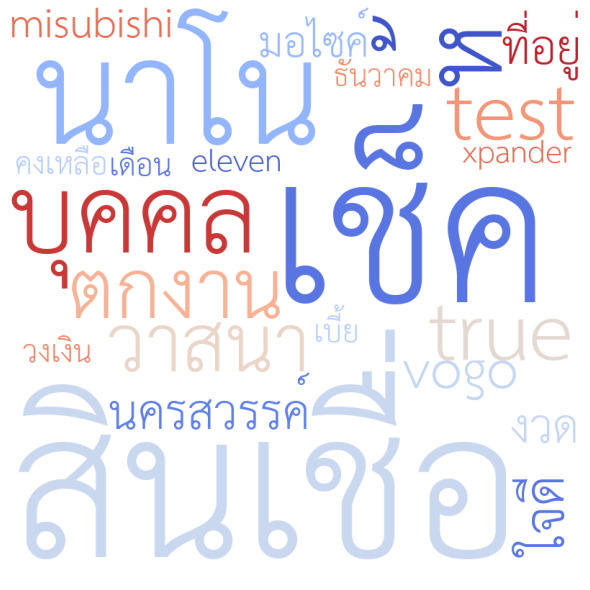

In [128]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.savefig('./WordCloud/keyword_{}.png'.format(td))

In [127]:
from datetime import date
today = date.today()
td = today.strftime("%Y-%m-%d")